# Retrieval: High Resolution Emission Spectroscopy on WASP-77Ab


This tutorial covers how to run a retrieval with high resolution data using POSEIDON. We will reproduce the result from [Brogi and Line 2019](https://ui.adsabs.harvard.edu/abs/2021Natur.598..580L/abstract), demonstrating the viabilty of our framework and a $\rm{H}_2\rm{O}$ and $\rm{CO}_2$ detection on WASP-77Ab.

### Preparing data
We start from a wavelength-aligned, preprocessed high resolution raw flux for our planet (WASP-77Ab) stored in a pickle file data_raw.pic. We perform Principal Component Analysis (PCA) to seperate the Doppler-Shifting planet emission and the stationary background consists of instrumental noise, telluric noise, and stellar flux.

In [12]:
import pickle
from POSEIDON.high_res import make_data_cube
import matplotlib.pyplot as plt

data_dir = "/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-77Ab/"  # Special directory for this tutorial
wl_grid, data_raw = pickle.load(open(data_dir + "data_raw.pic", "rb"))

In [10]:
data_scale, data_arr = make_data_cube(data_raw, wl_grid)

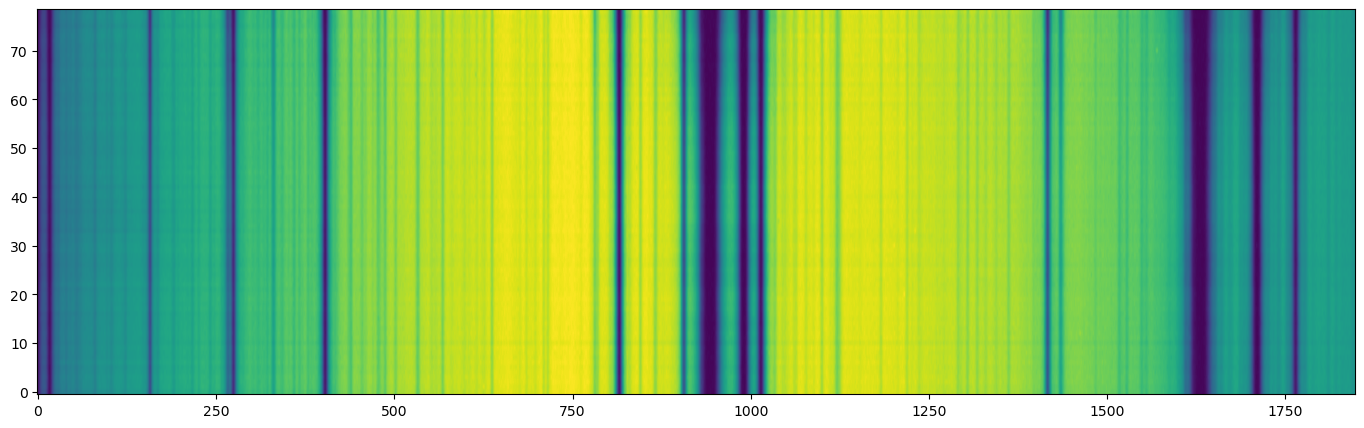

In [34]:
plt.figure(figsize=(17, 5))
plt.imshow(data_raw[0], aspect="auto", origin="lower", cmap="viridis")
plt.ticklabel_format(useOffset=False)

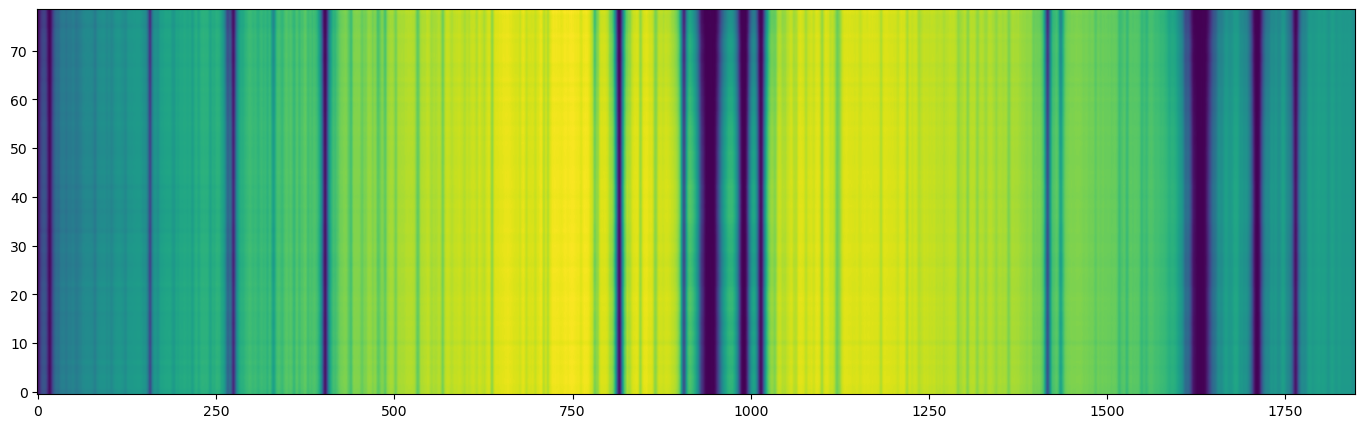

In [32]:
plt.figure(figsize=(17, 5))
plt.imshow(data_scale[0], aspect="auto", origin="lower", cmap="viridis")
plt.ticklabel_format(useOffset=False)

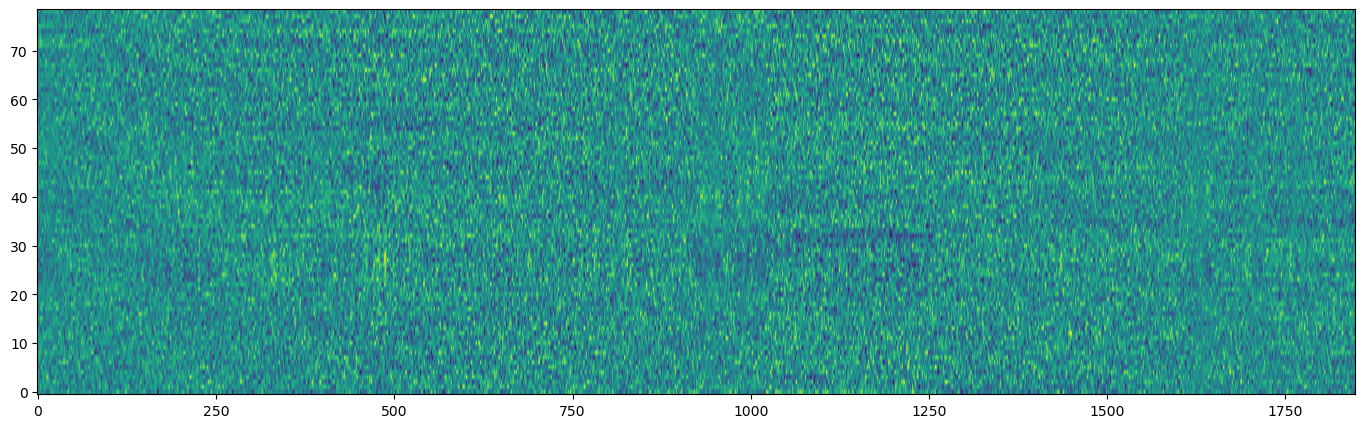

In [33]:
plt.figure(figsize=(17, 5))
plt.imshow(data_arr[0], aspect="auto", origin="lower", cmap="viridis")
plt.ticklabel_format(useOffset=False)

### Loading Data

After we prepare and save the data in the same directory, we can load them using read_high_res_data. We choose 'pca' as our filtering method. Another method is SYSREM. We demonstrate SYSREM in another tutorial.

In [35]:
from POSEIDON.utility import read_high_res_data

data_dir = "/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-77Ab/"  # Special directory for this tutorial

data = read_high_res_data(data_dir, method="pca", spectrum_type="emission")
data["V_sin_i"] = 4.5  # specify V_sin_i now in case we forget
data.keys()

dict_keys(['phi', 'method', 'spectrum_type', 'data_dir', 'high_res', 'wl_grid', 'data_arr', 'data_scale', 'V_bary', 'V_sin_i'])

### Wavelength Grid, Stellar and Planet Properties

Then, let's provide the wavelength grid and properties of the host star and your planet. The wavelength range should match the range of your data. This observation spans 0.37 microns to 0.51 microns.

In [2]:
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J, M_J

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# ***** Define stellar properties *****#

R_s = 0.91 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.48  # Stellar log surface gravity (log10(cm/s^2) by convention)

star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")

# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 1.76 * M_J  # Mass of planet (kg)
g_p = 10 ** (3.4765 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 1740  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

### Creating a Retrieval Model

Existing literature have shown detection of $\rm{H}_2\rm{O}$ and $\rm{C}\rm{O}_2$ in the atmosphere of WASP-77Ab.

So for a first attempt, we consider a model with $\rm{H}_2\rm{O}$ and $\rm{C}\rm{O}_2$, an isothermal temperature profile, and no clouds.

For additional parameters used in high resolution retrieval, we include: $a$ (the scale parameter), $K_p$ (the Keplerian orbital velocity), and $V_{sys}$ (the systematic velocity). An additional parameter available is $\Delta \phi$, which offsets the ephemeris.

In [3]:
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data

# ***** Define model *****#

model_name = "High-res retrieval"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# param_species = ['H2O', 'CO']  # H2O, CO as in Brogi & Line
param_species = []  # H2O, CO as in Brogi & Line

high_res_params = ["a", "dPhi", "K_p", "V_sys"]
# Create the model object
# model = define_model(model_name, bulk_species, param_species,
#                     PT_profile = 'Madhu',
#                     high_res_params = high_res_params, R_p_ref_enabled=False)
model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    high_res_params=high_res_params,
)
model["W_conv"] = 401
# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

Free parameters: ['R_p_ref' 'T' 'a' 'dPhi' 'K_p' 'V_sys']


### Setting Retrieval Priors

One of the most important aspects in any Bayesian analysis is deciding what priors to use for the free parameters. Specifying a prior has two steps: (i) choosing the type of probability distribution; and (ii) choosing the allowable range.

Most free parameters in atmospheric retrievals with POSEIDON use the following prior types:

- Uniform: you provide the minimum and maximum values for the parameter.
- Gaussian: you provide the mean and standard deviation for the parameter.

<div class="alert alert-info">

  **Note:**

  If you do not specify a prior type or range for a given parameter, POSEIDON will ascribe a default prior type (generally uniform) and a 'generous' range.

</div>


Your first retrieval is defined by three free parameters: (1) the isothermal atmospheric temperature; (2) the radius at the (fixed) reference pressure; (3) the log-mixing ratio of $\rm{Fe}$; and the four high resolution parameters. Since you don't have any *a priori* information on WASP-121b's atmosphere, you decide to use uniform priors for all the parameters. 

In [4]:
from POSEIDON.core import set_priors

# ***** Set priors for retrieval *****#

# Initialise prior type dictionary
prior_types = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types["T_ref"] = "uniform"
prior_types["T"] = "uniform"
prior_types["R_p_ref"] = "uniform"
prior_types["log_H2O"] = "uniform"
prior_types["log_CO"] = "uniform"
prior_types["log_CH4"] = "uniform"
prior_types["log_H2S"] = "uniform"
prior_types["log_NH3"] = "uniform"
prior_types["log_HCN"] = "uniform"
prior_types["a1"] = "uniform"
prior_types["a2"] = "uniform"
prior_types["log_P1"] = "uniform"
prior_types["log_P2"] = "uniform"
prior_types["log_P3"] = "uniform"
prior_types["K_p"] = "uniform"
prior_types["V_sys"] = "uniform"
prior_types["a"] = "gaussian"
prior_types["dPhi"] = "gaussian"
prior_types["b"] = "uniform"
prior_types["W_conv"] = "uniform"

# Initialise prior range dictionary
prior_ranges = {}

# Specify prior ranges for each free parameter
prior_ranges["T_ref"] = [500, 2000]
prior_ranges["T"] = [500, 2000]
prior_ranges["R_p_ref"] = [0.5 * R_p, 1.5 * R_p]
prior_ranges["log_H2O"] = [-12, 0]
prior_ranges["log_CO"] = [-12, 0]
prior_ranges["log_CH4"] = [-12, 0]
prior_ranges["log_H2S"] = [-12, 0]
prior_ranges["log_NH3"] = [-12, 0]
prior_ranges["log_HCN"] = [-12, 0]
prior_ranges["a1"] = [0.02, 1]
prior_ranges["a2"] = [0.02, 1]
prior_ranges["log_P1"] = [-5.5, 2.5]
prior_ranges["log_P2"] = [-5.5, 2.5]
prior_ranges["log_P3"] = [-2, 2]
prior_ranges["K_p"] = [180, 220]
prior_ranges["V_sys"] = [-20, 20]
prior_ranges["a"] = [0.01, 10]
prior_ranges["dPhi"] = [-0.01, 0.01]
prior_ranges["b"] = [0.1, 2]
prior_ranges["W_conv"] = [1, 50]

# Create prior object for retrieval
priors = set_priors(planet, star, model, data, prior_types, prior_ranges)

### Pre-load Opacities

The last step before running a retrieval is to pre-interpolate the cross sections for our model and store them in memory. For more details on this process, see the forward model tutorial.

<div class="alert alert-warning">

  **Warning:**

  Ensure the range of $T_{\rm{fine}}$ used for opacity pre-interpolation is at least as large as the desired prior range for temperatures to be explored in the retrieval. Any models with layer temperatures falling outside the range of $T_{\rm{fine}}$ will be automatically rejected (for retrievals with non-isothermal P-T profiles, this prevents unphysical profiles with negative temperatures etc.)

</div>

In [5]:
%env POSEIDON_input_data=/home/ryanm/POSEIDON
%env PYSYN_CDBS=/home/ryanm/POSEIDON/stellar_grid

env: POSEIDON_input_data=/home/ryanm/POSEIDON
env: PYSYN_CDBS=/home/ryanm/POSEIDON/stellar_grid


In [6]:
from POSEIDON.core import read_opacities
import numpy as np

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 500  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.5  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Opacity pre-interpolation complete.


### Run Retrieval

You are now ready to run your first high resolution atmospheric retrieval with SYSREM!

Here we will use the nested sampling algorithm MultiNest to explore the parameter space. The key input quantity you need to provide to MultiNest is called the *number of live points*, $N_{\rm{live}}$, which determines how finely the parameter space will be sampled (and hence the number of computed spectra). For exploratory retrievals, $N_{\rm{live}} = 400$ usually suffices. For publication-quality results, $N_{\rm{live}} = 2000$ is reasonable. 

This simple POSEIDON retrieval should take about 10 minutes on 1 core for a typical laptop.

<div class="alert alert-info">

  **Tip:**

  Retrievals run faster on multiple cores. When running the cells in this Jupyter notebook, only a single core will be used. You can run a multi-core retrieval on 4 cores by converting this Jupyter notebook into a python script, then calling mpirun on the .py file:

  ```
  mpirun -n 4 python -u YOUR_RETRIEVAL_SCRIPT.py
  ```
  
</div>


<div class="alert alert-info">

  **Important Note:**
  A high resolution forward model is computationally expensive (~1 second per model). With 400 live points, it took ~100,000 evalutations for the model to converge. With 36 cores, this amounts to ~1 hour. Therefore, there's no point in waiting for the next cell to finish. You should consider convert the notebook into a '.py' file and run it with multiple cores in command line.
  
</div>

In [7]:
from POSEIDON.retrieval import run_retrieval

# ***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
# P_ref = 10.0   # Reference pressure (bar)
P_ref = 1e-5  # Reference pressure (bar)


run_retrieval(
    planet,
    star,
    model,
    opac,
    data,
    priors,
    wl,
    P,
    P_ref,
    R=R,
    spectrum_type="emission",
    sampling_algorithm="MultiNest",
    N_live=400,
    verbose=True,
    N_output_samples=1000,
    resume=False,
    ev_tol=0.5,
)

POSEIDON now running 'High-res retrieval'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************
 Starting MultiNest
 generating live points
